In [1]:
import sys
import os
import json
import torch
import random
import numpy as np
from tqdm import tqdm
from PIL import Image
import re
from transformers import LlavaOnevisionForConditionalGeneration, AutoProcessor
from datasets import load_dataset, concatenate_datasets
from typing import Optional, Tuple
from torch import nn
import matplotlib.pyplot as plt
torch.set_grad_enabled(False)
import seaborn as sns
from types import MethodType

IOStream.flush timed out
/u/li19/data_folder/anaconda3/envs/mmlm/lib/python3.10/site-packages/transformers/utils/hub.py:128: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(


In [2]:
all_subs = [
    'Accounting', 'Agriculture', 'Architecture_and_Engineering', 'Art',
    # 'Art_Theory','Basic_Medical_Science','Biology','Chemistry','Clinical_Medicine',
    # 'Computer_Science','Design','Diagnostics_and_Laboratory_Medicine','Economics',
    # 'Electronics','Energy_and_Power','Finance','Geography','History','Literature',
    # 'Manage','Marketing','Materials','Math','Mechanical_Engineering','Music',
    'Pharmacy','Physics','Psychology','Public_Health','Sociology'
]
sub_dataset_list = [load_dataset("MMMU/mmmu", subject, split="validation") for subject in all_subs]
dataset = concatenate_datasets(sub_dataset_list)

In [3]:
model_id = "llava-hf/llava-onevision-qwen2-0.5b-ov-hf"
device = "cuda:0"
model = LlavaOnevisionForConditionalGeneration.from_pretrained(
    model_id,
    torch_dtype=torch.float16,
    trust_remote_code=True,
).to(device)
processor = AutoProcessor.from_pretrained(
    model_id,
    trust_remote_code=True
)

The argument `trust_remote_code` is to be used with Auto classes. It has no effect here and is ignored.
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.48, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [4]:
def repeat_kv(hidden_states: torch.Tensor, n_rep: int) -> torch.Tensor:
    """
    This is the equivalent of torch.repeat_interleave(x, dim=1, repeats=n_rep). The hidden states go from (batch,
    num_key_value_heads, seqlen, head_dim) to (batch, num_attention_heads, seqlen, head_dim)
    """
    batch, num_key_value_heads, slen, head_dim = hidden_states.shape
    if n_rep == 1:
        return hidden_states
    hidden_states = hidden_states[:, :, None, :, :].expand(batch, num_key_value_heads, n_rep, slen, head_dim)
    return hidden_states.reshape(batch, num_key_value_heads * n_rep, slen, head_dim)

def rotate_half(x):
    """Rotates half the hidden dims of the input."""
    x1 = x[..., : x.shape[-1] // 2]
    x2 = x[..., x.shape[-1] // 2 :]
    return torch.cat((-x2, x1), dim=-1)
    
def apply_rotary_pos_emb(q, k, cos, sin, position_ids=None, unsqueeze_dim=1):
    """Applies Rotary Position Embedding to the query and key tensors.

    Args:
        q (`torch.Tensor`): The query tensor.
        k (`torch.Tensor`): The key tensor.
        cos (`torch.Tensor`): The cosine part of the rotary embedding.
        sin (`torch.Tensor`): The sine part of the rotary embedding.
        position_ids (`torch.Tensor`, *optional*):
            Deprecated and unused.
        unsqueeze_dim (`int`, *optional*, defaults to 1):
            The 'unsqueeze_dim' argument specifies the dimension along which to unsqueeze cos[position_ids] and
            sin[position_ids] so that they can be properly broadcasted to the dimensions of q and k. For example, note
            that cos[position_ids] and sin[position_ids] have the shape [batch_size, seq_len, head_dim]. Then, if q and
            k have the shape [batch_size, heads, seq_len, head_dim], then setting unsqueeze_dim=1 makes
            cos[position_ids] and sin[position_ids] broadcastable to the shapes of q and k. Similarly, if q and k have
            the shape [batch_size, seq_len, heads, head_dim], then set unsqueeze_dim=2.
    Returns:
        `tuple(torch.Tensor)` comprising of the query and key tensors rotated using the Rotary Position Embedding.
    """
    cos = cos.unsqueeze(unsqueeze_dim)
    sin = sin.unsqueeze(unsqueeze_dim)
    q_embed = (q * cos) + (rotate_half(q) * sin)
    k_embed = (k * cos) + (rotate_half(k) * sin)
    return q_embed, k_embed


def verbose_scaled_dot_product_attention(query, key, value, attn_mask=None, dropout_p=0.0,
        is_causal=False, scale=None, enable_gqa=False) -> torch.Tensor:
    L, S = query.size(-2), key.size(-2)
    scale_factor = 1 / math.sqrt(query.size(-1)) if scale is None else scale
    attn_bias = torch.zeros(L, S, dtype=query.dtype, device=query.device)
    if is_causal:
        assert attn_mask is None
        temp_mask = torch.ones(L, S, dtype=torch.bool).tril(diagonal=0)
        attn_bias.masked_fill_(temp_mask.logical_not(), float("-inf"))
        attn_bias.to(query.dtype)

    if attn_mask is not None:
        if attn_mask.dtype == torch.bool:
            attn_bias.masked_fill_(attn_mask.logical_not(), float("-inf"))
        else:
            attn_bias = attn_mask + attn_bias

    if enable_gqa:
        key = key.repeat_interleave(query.size(-3)//key.size(-3), -3)
        value = value.repeat_interleave(query.size(-3)//value.size(-3), -3)

    attn_weight = query @ key.transpose(-2, -1) * scale_factor
    attn_weight += attn_bias
    attn_weight = torch.softmax(attn_weight, dim=-1)
    attn_weight = torch.dropout(attn_weight, dropout_p, train=True)
    return attn_weight @ value, attn_weight

def verbose_sdpa_attention_forward(
    module: torch.nn.Module,
    query: torch.Tensor,
    key: torch.Tensor,
    value: torch.Tensor,
    attention_mask: Optional[torch.Tensor],
    dropout: float = 0.0,
    scaling: Optional[float] = None,
    is_causal: Optional[bool] = None,
    **kwargs,
) -> Tuple[torch.Tensor, None]:
    if hasattr(module, "num_key_value_groups"):
        key = repeat_kv(key, module.num_key_value_groups)
        value = repeat_kv(value, module.num_key_value_groups)

    causal_mask = attention_mask
    if attention_mask is not None:
        causal_mask = causal_mask[:, :, :, : key.shape[-2]]

    # SDPA with memory-efficient backend is bugged with non-contiguous inputs and custom attn_mask for some torch versions
    # Reference: https://github.com/pytorch/pytorch/issues/112577.
    query = query.contiguous()
    key = key.contiguous()
    value = value.contiguous()

    # We dispatch to SDPA's Flash Attention or Efficient kernels via this `is_causal` if statement instead of an inline conditional assignment
    # in SDPA to support both torch.compile's dynamic shapes and full graph options. An inline conditional prevents dynamic shapes from compiling.
    # Note that it is important to check first for the shape, otherwise compile will fail with `argument 'is_causal' must be bool, not SymBool`
    if is_causal is None:
        is_causal = query.shape[2] > 1 and causal_mask is None

    # Shapes (e.g. query.shape[2]) are tensors during jit tracing, resulting in `is_causal` being a tensor.
    # We convert it to a bool for the SDPA kernel that only accepts bools.
    if torch.jit.is_tracing() and isinstance(is_causal, torch.Tensor):
        is_causal = is_causal.item()

    attn_output, attn_weight = verbose_scaled_dot_product_attention(
        query,
        key,
        value,
        attn_mask=causal_mask,
        dropout_p=dropout,
        scale=scaling,
        is_causal=is_causal,
    )
    attn_output = attn_output.transpose(1, 2).contiguous()

    return attn_output, attn_weight

def verbose_forward(
        self,
        hidden_states: torch.Tensor,
        position_embeddings: Tuple[torch.Tensor, torch.Tensor],
        attention_mask: Optional[torch.Tensor],
        past_key_value=None,
        cache_position: Optional[torch.LongTensor] = None,
        **kwargs,
    ) -> Tuple[torch.Tensor, Optional[torch.Tensor], Optional[Tuple[torch.Tensor]]]:
        input_shape = hidden_states.shape[:-1]
        hidden_shape = (*input_shape, -1, self.head_dim)

        query_states = self.q_proj(hidden_states).view(hidden_shape).transpose(1, 2)
        key_states = self.k_proj(hidden_states).view(hidden_shape).transpose(1, 2)
        value_states = self.v_proj(hidden_states).view(hidden_shape).transpose(1, 2)

        cos, sin = position_embeddings
        query_states, key_states = apply_rotary_pos_emb(query_states, key_states, cos, sin)

        if past_key_value is not None:
            # sin and cos are specific to RoPE models; cache_position needed for the static cache
            cache_kwargs = {"sin": sin, "cos": cos, "cache_position": cache_position}
            key_states, value_states = past_key_value.update(key_states, value_states, self.layer_idx, cache_kwargs)

        sliding_window = None
        if (
            self.config.use_sliding_window
            and getattr(self.config, "sliding_window", None) is not None
            and self.layer_idx >= self.config.max_window_layers
        ):
            sliding_window = self.config.sliding_window

        attn_output, attn_weights = verbose_sdpa_attention_forward(
            self,
            query_states,
            key_states,
            value_states,
            attention_mask,
            dropout=0.0 if not self.training else self.attention_dropout,
            scaling=self.scaling,
            sliding_window=sliding_window,  # main diff with Llama
            **kwargs,
        )

        attn_output = attn_output.reshape(*input_shape, -1).contiguous()
        attn_output = self.o_proj(attn_output)
        return attn_output, attn_weights

In [5]:
# Optionally, if you want to keep a reference to the original forward method:
for layer in model.language_model.model.layers:
    obj = layer.self_attn
    obj._original_forward = obj.forward  # save the original forward if needed
    obj.forward = MethodType(verbose_forward, obj)

In [6]:
def test_vision_attn(image):
    instruct = "you are an advanced question answer model, please answer this question to the best of your ability with a single letter in brackets like this [X]."
    question_text = "Who created <image 1>?"
    answers = 'A: ARKHIP KUINII B: PAUL SIGNAC C: GEORGES SEURAT D: VALENTIN SEROV'
    
    content = [
        {"type": "text", "text": instruct},
        {"type": "image"},
        {"type": "text", "text": question_text},
        {"type": "text", "text": answers},
    ]
    response = {"role": "user", "content": content}
    prompt = processor.apply_chat_template([response], add_generation_prompt=True)
    inputs = processor(
        text=[prompt],
        images=[image],
        return_tensors="pt",
        padding=True
    )
    for k in inputs:
        inputs[k] = inputs[k].to(device)
    
    generation_config = {
        "max_new_tokens": 32,
        "temperature": 1.0,
        "do_sample": False,
        "num_beams": 1,
        "repetition_penalty": 1.0,
        "length_penalty": 1.0,
        "early_stopping": True,
        "pad_token_id": processor.tokenizer.eos_token_id,
        "return_dict_in_generate": True,
        "output_attentions": True
    }

    with torch.no_grad():
        output = model(
            **inputs, output_attentions=True
        )
        return output

    #     attn = output.attention

    #     responses = processor.batch_decode(
    #         output.sequences,
    #         skip_special_tokens=True,
    #         clean_up_tokenization_spaces=False
    #     )
    # resp = responses[0].split("\n")
    # return resp[-1] == "C", output, inputs

In [7]:
img = dataset[100]['image_1']
# valid, output, inputs = test_vision_attn(img)
output = test_vision_attn(img)

In [8]:
output.keys()
attns = torch.stack(output.attentions).detach().cpu()

OutOfMemoryError: CUDA out of memory. Tried to allocate 26.14 GiB. GPU 0 has a total capacty of 39.38 GiB of which 9.00 GiB is free. Including non-PyTorch memory, this process has 30.38 GiB memory in use. Of the allocated memory 29.77 GiB is allocated by PyTorch, and 103.91 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

# Example Run

In [4]:
def plot_attention_map(tokens, attention_scores):
    # Ensure the number of tokens and attention scores match
    assert len(tokens) == len(attention_scores), "Tokens and attention scores must have the same length."
    
    # Calculate the number of rows and columns for a square-like layout
    num_tokens = len(tokens)
    cols = int(np.ceil(np.sqrt(num_tokens)))  # Number of columns
    rows = int(np.ceil(num_tokens / cols))    # Number of rows
    
    # Create a figure and axis
    fig, ax = plt.subplots(figsize=(cols, rows))
    
    # Normalize attention scores for color mapping
    norm = plt.Normalize(vmin=min(attention_scores), vmax=max(attention_scores))
    colors = plt.cm.viridis(norm(attention_scores))
    
    # Plot each token with a colored box
    for i, (token, score) in enumerate(zip(tokens, attention_scores)):
        # Calculate row and column position
        row = i // cols
        col = i % cols
        
        # Create a rectangle with the color corresponding to the attention score
        rect = plt.Rectangle((col, row), 1, 1, color=colors[i], alpha=0.6)
        ax.add_patch(rect)
        
        # Add the token text in the center of the rectangle
        ax.text(col + 0.5, row + 0.5, token, ha='center', va='center', fontsize=12, color='black')
    
    # Set limits and remove axes
    ax.set_xlim(0, cols)
    ax.set_ylim(0, rows)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_aspect('equal')
    
    # Add a colorbar to show the attention score scale
    sm = plt.cm.ScalarMappable(cmap='viridis', norm=norm)
    sm.set_array([])
    plt.colorbar(sm, ax=ax, orientation='vertical', fraction=0.046, pad=0.04)
    
    plt.tight_layout()
    plt.show()

def test_model():
    instruct = "you are an advanced question answer model, please answer this question to the best of your ability with a single letter in brackets like this [X]."
    sample_text = "what temperature is it likely to be in winter "
    answers = "A: cold B: hot "
    
    content = [
        {"type": "text", "text": instruct},
        {"type": "text", "text": sample_text},
        {"type": "text", "text": answers},
    ]
    response = {"role": "user", "content": content}

    
    prompt = processor.apply_chat_template([response], add_generation_prompt=True)
    
    inputs = processor(
        text=[prompt],
        images=None,
        return_tensors="pt",
        padding=True
    )
    for k in inputs:
        inputs[k] = inputs[k].to(device)
    
        
    generation_config = {
        "max_new_tokens": 32,
        "temperature": 1.0,
        "do_sample": False,
        "num_beams": 1,
        "repetition_penalty": 1.0,
        "length_penalty": 1.0,
        "early_stopping": True,
        "pad_token_id": processor.tokenizer.eos_token_id,
        "return_dict_in_generate": True,
        "output_attentions": True
    }

    
    with torch.no_grad():
        output = model.generate(
            **inputs, **generation_config
        ).detach()

        responses = processor.batch_decode(
            output.sequences,
            skip_special_tokens=True,
            clean_up_tokenization_spaces=False
        )
    resp = responses[0].split("\n")
    return resp[-1] == "A", output, inputs

def test_vision(image):
    instruct = "you are an advanced question answer model, please answer this question to the best of your ability with a single letter in brackets like this [X]."
    question_text = "Who created <image 1>?"
    answers = 'A: ARKHIP KUINII B: PAUL SIGNAC C: GEORGES SEURAT D: VALENTIN SEROV'
    
    content = [
        {"type": "text", "text": instruct},
        {"type": "image"},
        {"type": "text", "text": question_text},
        {"type": "text", "text": answers},
    ]
    response = {"role": "user", "content": content}
    prompt = processor.apply_chat_template([response], add_generation_prompt=True)
    inputs = processor(
        text=[prompt],
        images=[image],
        return_tensors="pt",
        padding=True
    )
    for k in inputs:
        inputs[k] = inputs[k].to(device)
    
    generation_config = {
        "max_new_tokens": 32,
        "temperature": 1.0,
        "do_sample": False,
        "num_beams": 1,
        "repetition_penalty": 1.0,
        "length_penalty": 1.0,
        "early_stopping": True,
        "pad_token_id": processor.tokenizer.eos_token_id,
        "return_dict_in_generate": True,
        "output_attentions": True
    }

    with torch.no_grad():
        output = model.generate(
            **inputs, **generation_config
        ).detach()

        responses = processor.batch_decode(
            output.sequences,
            skip_special_tokens=True,
            clean_up_tokenization_spaces=False
        )
    resp = responses[0].split("\n")
    return resp[-1] == "C", output, inputs
    
def extend_attention_map(attention_map, new_token_attention):
    """
    Extends an attention map with new token attention values.
    
    Args:
        attention_map (torch.Tensor): Current attention map of shape (53, 53)
        new_token_attention (torch.Tensor): Attention vector for new token of length 54
    
    Returns:
        torch.Tensor: Extended attention map of shape (54, 54)
    """
    # Reshape new token attention to be a row vector
    new_row = new_token_attention.unsqueeze(0)  # Shape: (1, 54)
    
    # Pad the existing attention map with the new token attention values
    # First, add the new column
    extended_map = torch.cat([attention_map, new_token_attention[:53].unsqueeze(1)], dim=1)  # Shape: (53, 54)
    
    # Then add the new row
    final_map = torch.cat([extended_map, new_row], dim=0)  # Shape: (54, 54)
    
    return final_map

In [5]:
valid, output, inputs = test_model()

/u/li19/data_folder/anaconda3/envs/mmlm/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:676: UserWarning: `num_beams` is set to 1. However, `early_stopping` is set to `True` -- this flag is only used in beam-based generation modes. You should set `num_beams>1` or unset `early_stopping`.
  warnings.warn(
`torch.nn.functional.scaled_dot_product_attention` does not support `output_attentions=True`. Falling back to eager attention. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.
From v4.47 onwards, when a model cache is to be returned, `generate` will return a `Cache` instance instead by default (as opposed to the legacy tuple of tuples format). If you want to keep returning the legacy format, please set `return_legacy_cache=True`.


In [6]:
seq = output.sequences
responses = processor.batch_decode(
    seq,
    skip_special_tokens=True,
    clean_up_tokenization_spaces=False
)
responses

['user \nyou are an advanced question answer model, please answer this question to the best of your ability with a single letter in brackets like this [X].\nwhat temperature is it likely to be in winter \nA: cold B: hot assistant\nA']

In [7]:
output['attentions'][0][0][0, 0, 0, :].shape

torch.Size([53])

In [8]:
output['attentions'][1][0].shape

torch.Size([1, 14, 1, 54])

In [9]:
targ_token = -1
targ_head = 0
cuttoff_idx = 32
if targ_token > 0:
    targ_token += cuttoff_idx

full_attn = torch.cat((output['attentions'][0][0][0, 0, 0, :].cpu(), torch.tensor([output['attentions'][1][0][0, 0, 0, 0]])))

attn_weights = torch.zeros_like(full_attn)
n_heads = len(output['attentions'][0][0][0, :, 0, 0])
for i in range(n_heads):
    attn_weights +=  torch.cat((output['attentions'][0][-1][0, i, :, targ_token].cpu(), torch.tensor([output['attentions'][1][-1][0, i, 0, targ_token]])))
attn_weights /= n_heads


final_tokens = tokens[cuttoff_idx:-1]
final_wights = attn_weights.cpu()[cuttoff_idx:]
final_wights = np.clip(final_wights, 0, 0.1)
# plot_academic_attention(final_tokens, final_wights)

In [10]:


full_attn = extend_attention_map(output['attentions'][0][0][0, 0, :, :].cpu(), output['attentions'][1][0][0, 0, 0, :].cpu())

n_heads = len(output['attentions'][0][0][0, :, 0, 0])
cutoff = 32
attn_weights = torch.zeros_like(full_attn)
for i in range(n_heads):
    attn_weights +=extend_attention_map(
        output['attentions'][0][0][0, i, :, :].cpu(), 
        output['attentions'][1][0][0, i, 0, :].cpu()
    )
    
attn_weights /= n_heads



# fig, ax = plot_attention_map(tokens[cutoff:-1], attn_weights[cutoff:, cutoff:])
# plt.show()

In [11]:
img = dataset[100]['image_1']
valid, output, inputs = test_vision(img)

In [51]:
seq = output.sequences
tokens = [processor.batch_decode([token]) for token in seq[0]]

In [52]:
seq = inputs.input_ids
input_tokens = [processor.batch_decode([token]) for token in seq[0]]

In [53]:
print(output.attentions[0][-1].shape)
print(output.attentions[1][-1].shape)

torch.Size([1, 14, 6463, 6463])
torch.Size([1, 14, 1, 6464])


In [14]:
targ_token = -1
targ_head = 0
attn = output.attentions[0][0]
attn_weights = attn[0, targ_head, targ_token, :]
attn_weights.shape

torch.Size([6463])

In [35]:
nImg = len([t for t in tokens if t == ["<image>"]])
nImg

6387

In [16]:
text_tokens = []
text_attn_idx = []

for idx, token in enumerate(tokens):
    if token != ["<image>"]:
        text_tokens.append(token)
        text_attn_idx.append(idx)

In [36]:
len(textWeights)

76

In [37]:
len(attn_weights)

6463

In [38]:
len(tokens)

6465

In [18]:
patch_attentions = attn_weights[3:nImg+3].cpu()
textTokens = tokens[nImg + 3:]
textWeights = attn_weights[nImg:].cpu()
print(patch_attentions.shape)
print(textWeights.shape)

torch.Size([6387])
torch.Size([76])


<BarContainer object of 76 artists>

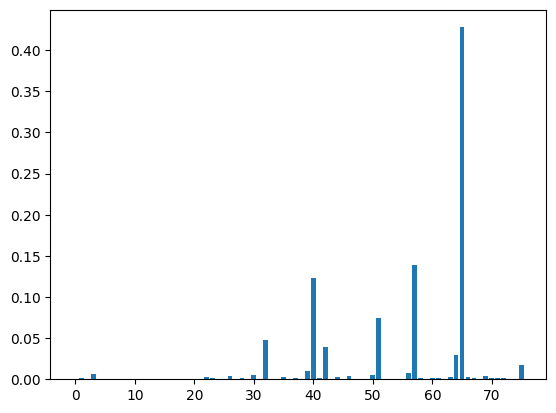

In [19]:
plt.bar(range(len(textWeights)), textWeights)

tensor(0.0011, dtype=torch.float16)

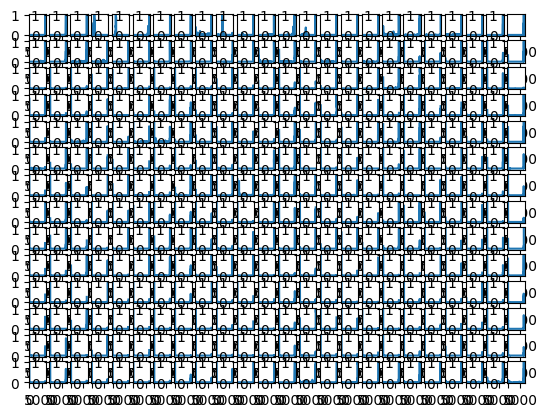

In [109]:
heads = range(14)
layers = range(24)
attn = output.attentions[0][0]

fig, axs = plt.subplots(14, 24)

for idx, ax in enumerate(axs.flatten()):
    layer = int(idx / 14)
    head = idx % 14
    
    targ_weight = output.attentions[0][layer].cpu()
    targ_weight = targ_weight[0, head, -1, :]
    
    normed = targ_weight - targ_weight.min()
    normed = normed / normed.max()
    
    ax.plot(range(len(normed)), normed)

In [86]:
len(tokens)

6465

In [20]:
len(attn_weights)

6463

In [23]:
len(text_tokens)

78

In [24]:
len(textWeights)

76

In [31]:
output.attentions[0][0].shape

torch.Size([1, 14, 6463, 6463])

In [34]:
output.attentions[1][0].shape

torch.Size([1, 14, 1, 6464])

In [58]:
output.attentions[1][-1].shape

torch.Size([1, 14, 1, 6464])

In [79]:
tokens[6463:]

[['B'], ['<|im_end|>']]

In [74]:
pairs = [[token[0], float(weight)] for token, weight in zip(tokens, output.attentions[1][-1][0, -1, 0, :].cpu()) if token != ["<image>"]]
len(pairs)

77

In [71]:
[p[0] for p in pairs]

['<|im_start|>',
 'user',
 ' ',
 '\n',
 'you',
 ' are',
 ' an',
 ' advanced',
 ' question',
 ' answer',
 ' model',
 ',',
 ' please',
 ' answer',
 ' this',
 ' question',
 ' to',
 ' the',
 ' best',
 ' of',
 ' your',
 ' ability',
 ' with',
 ' a',
 ' single',
 ' letter',
 ' in',
 ' brackets',
 ' like',
 ' this',
 ' [',
 'X',
 '].\n',
 'Who',
 ' created',
 ' <',
 'image',
 ' ',
 '1',
 '>',
 '?\n',
 'A',
 ':',
 ' AR',
 'K',
 'HIP',
 ' K',
 'U',
 'IN',
 'II',
 ' B',
 ':',
 ' PA',
 'UL',
 ' SIGN',
 'AC',
 ' C',
 ':',
 ' GE',
 'ORG',
 'ES',
 ' SE',
 'UR',
 'AT',
 ' D',
 ':',
 ' VA',
 'LE',
 'NT',
 'IN',
 ' SER',
 'OV',
 '<|im_end|>',
 '<|im_start|>',
 'assistant',
 '\n',
 'B']

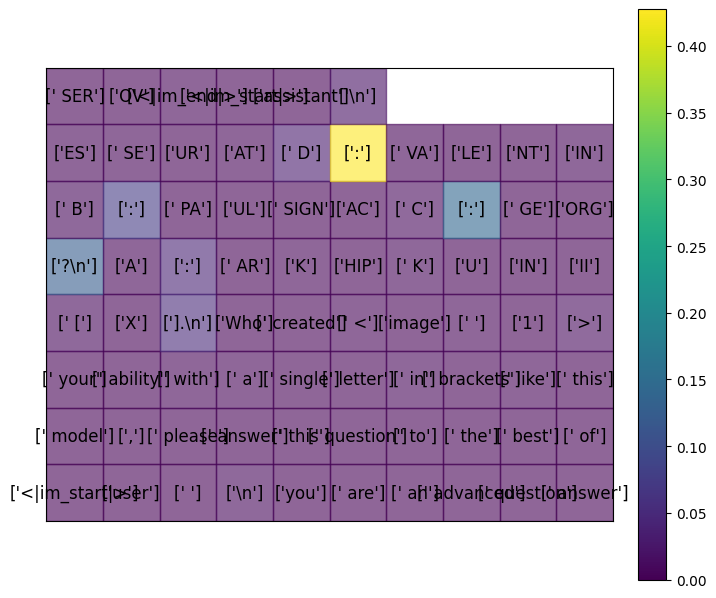

In [134]:
plot_attention_map(
    [p[0] for p in pairs],
    [p[1] for p in pairs]
)

In [135]:
inputs['pixel_values'].shape
# bzs, patches, colors, xpix, ypix

torch.Size([1, 10, 3, 384, 384])

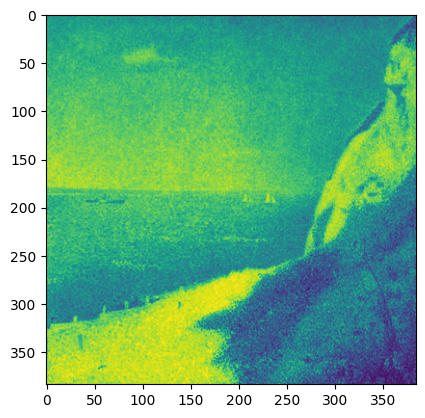

In [136]:
show_img = inputs['pixel_values'][0, 0, 0, :, :].cpu().numpy()
plt.imshow(show_img)

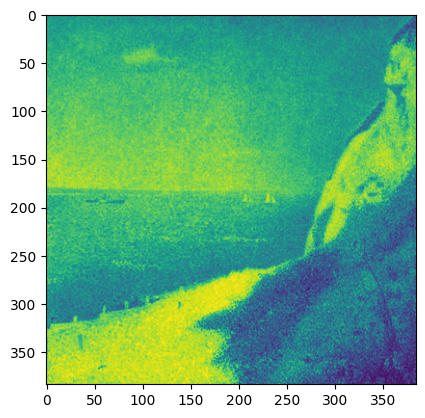

In [137]:
show_img = inputs['pixel_values'][0, 0, 0, :, :].cpu().numpy()
plt.imshow(show_img)

In [167]:
model.vision_tower

SiglipVisionModel(
  (vision_model): SiglipVisionTransformer(
    (embeddings): SiglipVisionEmbeddings(
      (patch_embedding): Conv2d(3, 1152, kernel_size=(14, 14), stride=(14, 14), padding=valid)
      (position_embedding): Embedding(729, 1152)
    )
    (encoder): SiglipEncoder(
      (layers): ModuleList(
        (0-25): 26 x SiglipEncoderLayer(
          (self_attn): SiglipSdpaAttention(
            (k_proj): Linear(in_features=1152, out_features=1152, bias=True)
            (v_proj): Linear(in_features=1152, out_features=1152, bias=True)
            (q_proj): Linear(in_features=1152, out_features=1152, bias=True)
            (out_proj): Linear(in_features=1152, out_features=1152, bias=True)
          )
          (layer_norm1): LayerNorm((1152,), eps=1e-06, elementwise_affine=True)
          (mlp): SiglipMLP(
            (activation_fn): PytorchGELUTanh()
            (fc1): Linear(in_features=1152, out_features=4304, bias=True)
            (fc2): Linear(in_features=4304, out_feat

In [138]:
patch_attentions.shape

torch.Size([6387])

In [139]:
np.array(img).shape

(860, 1018, 4)

In [140]:
print(inputs['image_sizes'], inputs['pixel_values'].shape)

tensor([[ 860, 1018]], device='cuda:0') torch.Size([1, 10, 3, 384, 384])


In [163]:
image_features = model.get_image_features(
    inputs['pixel_values'],
    inputs['image_sizes'],
    vision_feature_layer=model.config.vision_feature_layer,
    vision_feature_select_strategy=model.config.vision_feature_select_strategy,
)

print(len(image_features))
print(len(image_features[0]))
print(len(image_features[0][0]))
print(len(image_features[0][0][0]))

1
10
729
896


In [157]:
image_features, feature_lens = model.pack_image_features(
    image_features,
    inputs['image_sizes'],
    image_newline=model.image_newline,
    vision_aspect_ratio=model.config.vision_aspect_ratio,
)
n_image_tokens = (inputs['input_ids'] == model.config.image_token_index).sum().item()
n_image_features = image_features.shape[0]
print(n_image_tokens, n_image_features)

6387 6387


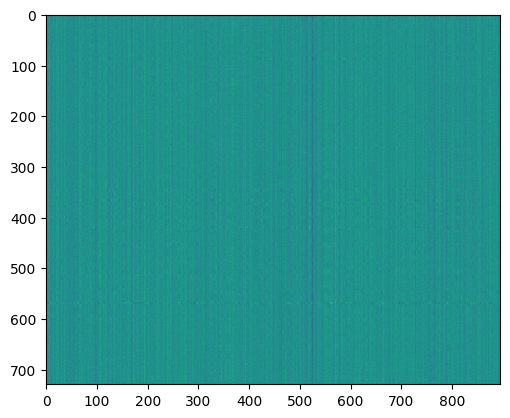

In [165]:
plt.imshow(image_features[0][0].cpu())

In [144]:
feature_lens

tensor([6387], device='cuda:0')

# Pipeline Replication

In [ ]:


def select_best_resolution(original_size: tuple, possible_resolutions: list) -> tuple:
    """
    Selects the best resolution from a list of possible resolutions based on the original size.

    This is done by calculating the effective and wasted resolution for each possible resolution.

    The best fit resolution is the one that maximizes the effective resolution and minimizes the wasted resolution.

    Args:
        original_size (tuple):
            The original size of the image in the format (height, width).
        possible_resolutions (list):
            A list of possible resolutions in the format [(height1, width1), (height2, width2), ...].

    Returns:
        tuple: The best fit resolution in the format (height, width).
    """
    original_height, original_width = original_size
    best_fit = None
    max_effective_resolution = 0
    min_wasted_resolution = float("inf")

    for height, width in possible_resolutions:
        scale = min(width / original_width, height / original_height)
        downscaled_width, downscaled_height = int(original_width * scale), int(original_height * scale)
        effective_resolution = min(downscaled_width * downscaled_height, original_width * original_height)
        wasted_resolution = (width * height) - effective_resolution

        if effective_resolution > max_effective_resolution or (
            effective_resolution == max_effective_resolution and wasted_resolution < min_wasted_resolution
        ):
            max_effective_resolution = effective_resolution
            min_wasted_resolution = wasted_resolution
            best_fit = (height, width)

    return best_fit

# Copied from transformers.models.llava_next.modeling_llava_next.image_size_to_num_patches
def image_size_to_num_patches(image_size, grid_pinpoints, patch_size: int):
    """
    Calculate the number of patches after the preprocessing for images of any resolution.

    Args:
        image_size (`torch.LongTensor` or `np.ndarray` or `Tuple[int, int]`):
            The size of the input image in the format (height, width). ?
        grid_pinpoints (`List`):
            A list containing possible resolutions. Each item in the list should be a tuple or list
            of the form `(height, width)`.
        patch_size (`int`):
            The size of each image patch.

    Returns:
        int: the number of patches
    """
    if not isinstance(grid_pinpoints, list):
        raise TypeError("grid_pinpoints should be a list of tuples or lists")

    # ! VERY IMPORTANT if image_size is tensor, must convert to into tuple, otherwise it will cause wrong calculate
    if not isinstance(image_size, (list, tuple)):
        if not isinstance(image_size, (torch.Tensor, np.ndarray)):
            raise TypeError(f"image_size invalid type {type(image_size)} with value {image_size}")
        image_size = image_size.tolist()

    best_resolution = select_best_resolution(image_size, grid_pinpoints)
    height, width = best_resolution
    num_patches = 0
    # consider change to ceil(height/patch_size)*ceil(width/patch_size) + 1
    for i in range(0, height, patch_size):
        for j in range(0, width, patch_size):
            num_patches += 1
    # add the base patch
    num_patches += 1
    return num_patches

In [ ]:
n = image_size_to_num_patches(
    image_size=inputs['image_sizes'][0],
    grid_pinpoints=model.config.image_grid_pinpoints,
    patch_size=model.config.vision_config.image_size
)

In [113]:
len(inputs.input_ids[0])

6463

In [115]:
output.attentions[0][0].shape

torch.Size([1, 14, 6463, 6463])

In [123]:
tokens = [processor.batch_decode([token]) for token in seq[0]]
attention_scores = output.attentions[0][0]
targ_token = -1
pairs = [[token, attn.cpu()] for token, attn in zip(tokens, attention_scores[0, 0, targ_token, :]) if token != ["<image>"]]

<BarContainer object of 76 artists>

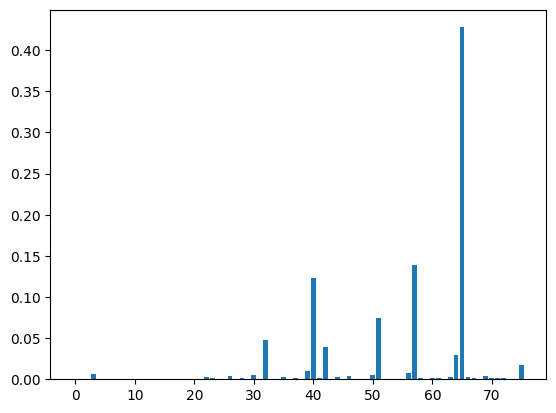

In [127]:
plt.bar(range(len([p[1] for p in pairs])), [p[1] for p in pairs])

In [131]:
tokens = [processor.batch_decode([token]) for token in seq[0]]
attention_scores = output.attentions[0][0]
targ_token = -1
image_pairs = [[token, attn.cpu()] for token, attn in zip(tokens, attention_scores[0, 0, targ_token, :]) if token == ["<image>"]]

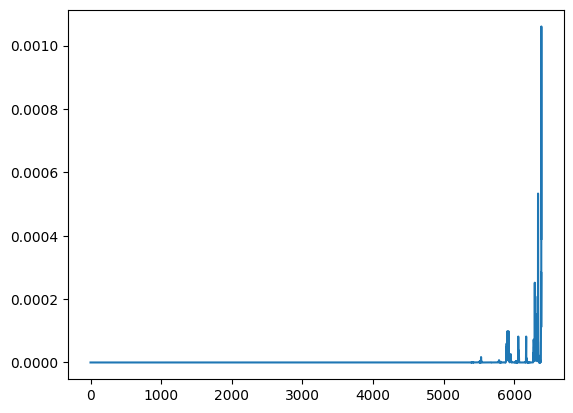

In [133]:
plt.plot(range(len([p[1] for p in image_pairs])), [p[1] for p in image_pairs])